<a href="https://colab.research.google.com/github/paulynamagana/afdb-analysis-tools/blob/main/notebooks/dssp-contact-map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title <font color='#e59454' >1.Install Dependencies </font>
# Install necessary python libraries, DSSP, and FreeSASA
!pip install -q biopython matplotlib numpy requests py3Dmol
!apt-get install -qq dssp
print("Dependencies installed.")

Preconfiguring packages ...
Selecting previously unselected package libcifpp-data.
(Reading database ... 126210 files and directories currently installed.)
Preparing to unpack .../libcifpp-data_2.0.5-1build1_all.deb ...
Unpacking libcifpp-data (2.0.5-1build1) ...
Selecting previously unselected package libcifpp2:amd64.
Preparing to unpack .../libcifpp2_2.0.5-1build1_amd64.deb ...
Unpacking libcifpp2:amd64 (2.0.5-1build1) ...
Selecting previously unselected package dssp.
Preparing to unpack .../dssp_4.0.4-1_amd64.deb ...
Unpacking dssp (4.0.4-1) ...
Setting up libcifpp-data (2.0.5-1build1) ...
Setting up libcifpp2:amd64 (2.0.5-1build1) ...
Setting up dssp (4.0.4-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/

In [2]:
#@title <font color='#e59454' >2.Import Libraries
import os
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
import traceback
import warnings
import py3Dmol
import json


# Suppress specific Biopython PDB warnings (optional, but cleans up output)
warnings.filterwarnings("ignore", category=UserWarning, module='Bio.PDB.PDBParser')


In [12]:
# --- Configuration ---
#@markdown Enter the UniProt ID for the protein structure you want to visualize:
uniprot_id = "P00558" #@param {type:"string"}
#@markdown Directory to save downloaded files:
files_dir = "alphafold_files" #@param {type:"string"} # Renamed variable


In [13]:
#@title <font color='#e59454' >3.Data fetching and processing functions

def download_alphafold_files(uniprot_id: str, save_dir: str = "alphafold_files") -> tuple[str | None, str | None]:
    """
    Downloads AlphaFold PDB and PAE JSON files for a given UniProt ID.

    Args:
        uniprot_id: The UniProt accession ID.
        save_dir: The directory where the files will be saved.

    Returns:
        A tuple containing (pdb_file_path, pae_file_path).
        Returns (None, None) if any download fails.
    """
    os.makedirs(save_dir, exist_ok=True)

    # URLs and local file paths
    pdb_url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"
    pae_url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-predicted_aligned_error_v4.json"
    pdb_file_path = os.path.join(save_dir, f"AF-{uniprot_id}-F1-model_v4.pdb")
    pae_file_path = os.path.join(save_dir, f"AF-{uniprot_id}-F1-predicted_aligned_error_v4.json")

    # --- Download PDB ---
    if os.path.exists(pdb_file_path):
        print(f"PDB file already exists: {pdb_file_path}")
    else:
        print(f"Downloading PDB for {uniprot_id}...")
        try:
            response_pdb = requests.get(pdb_url, timeout=30)
            response_pdb.raise_for_status()
            with open(pdb_file_path, "wb") as f:
                f.write(response_pdb.content)
            print(f"Successfully downloaded: {pdb_file_path}")
        except requests.exceptions.RequestException as e:
            print(f"ERROR: Failed to download PDB file for {uniprot_id}. {e}")
            pdb_file_path = None # Mark as failed

    # --- Download PAE ---
    if os.path.exists(pae_file_path):
        print(f"PAE JSON file already exists: {pae_file_path}")
    else:
        # Only attempt download if PDB path is still valid (optional dependency)
        if pdb_file_path:
            print(f"Downloading PAE JSON for {uniprot_id}...")
            try:
                response_pae = requests.get(pae_url, timeout=30)
                response_pae.raise_for_status()
                with open(pae_file_path, "w") as f: # Write as text
                    f.write(response_pae.text)
                print(f"Successfully downloaded: {pae_file_path}")
            except requests.exceptions.RequestException as e:
                print(f"ERROR: Failed to download PAE JSON file for {uniprot_id}. {e}")
                pae_file_path = None # Mark as failed
        else:
             pae_file_path = None # Cannot download PAE if PDB failed

    # Return None for a path if it doesn't exist after download attempts
    if not os.path.exists(pdb_file_path): pdb_file_path = None
    if not os.path.exists(pae_file_path): pae_file_path = None

    return pdb_file_path, pae_file_path

def get_plddt_and_residues(pdb_file: str) -> tuple[list[int], list[float]] | tuple[None, None]:
    """
    Extracts residue numbers and pLDDT scores from an AlphaFold PDB file.

    pLDDT (predicted Local Distance Difference Test) is a per-residue confidence
    score from AlphaFold, stored in the B-factor column of the PDB file.

    Args:
        pdb_file: Path to the PDB file.

    Returns:
        A tuple containing:
        - list of residue numbers (integers, 1-based).
        - list of corresponding pLDDT scores (floats).
        Returns (None, None) if extraction fails.
    """
    residues_list = []
    plddt_scores = []
    processed_residue_ids = set()

    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("AF_structure", pdb_file)
        model = structure[0]

        for chain in model:
            for residue in chain:
                hetfield, resseq, icode = residue.get_id()
                residue_full_id = (chain.id, hetfield, resseq, icode)

                # Process only standard amino acid residues (' ') once
                if hetfield != ' ' or residue_full_id in processed_residue_ids:
                    continue

                # Extract B-factor (pLDDT) from C-alpha atom (or first atom as fallback)
                try:
                    target_atom = residue['CA'] if 'CA' in residue else next(iter(residue))
                    plddt = target_atom.get_bfactor()
                    residues_list.append(resseq)
                    plddt_scores.append(plddt)
                    processed_residue_ids.add(residue_full_id)
                except (KeyError, StopIteration):
                     print(f"Warning: Could not find suitable atom or B-factor for residue {resseq} in chain {chain.id}.")
                     continue # Skip residue if pLDDT cannot be extracted

        # Ensure data is sorted by residue number
        if residues_list:
            sorted_pairs = sorted(zip(residues_list, plddt_scores))
            residues_list, plddt_scores = [list(t) for t in zip(*sorted_pairs)]
            print(f"Extracted pLDDT for {len(residues_list)} residues.")
            return residues_list, plddt_scores
        else:
            print("ERROR: No residues found or pLDDT scores extracted.")
            return None, None

    except Exception as e:
        print(f"ERROR: Failed to parse PDB or extract pLDDT scores from {pdb_file}. {e}")
        # traceback.print_exc() # Uncomment for detailed debugging if needed
        return None, None


def get_dssp_results(pdb_file: str) -> tuple[dict, dict] | tuple[None, None]:
    """
    Calculates secondary structure and accessibility using DSSP.

    DSSP assigns secondary structure (H, E, T, etc.) and also calculates
    an accessibility value (number of water contacts). This function returns
    both, mapped to residue numbers.

    Requires the 'dssp' or 'mkdssp' executable.

    Args:
        pdb_file: Path to the PDB file.

    Returns:
        A tuple containing (ss_dict, acc_dict), or (None, None) if DSSP fails.
        - ss_dict: {res_id: simplified_ss_type (str)}
        - acc_dict: {res_id: dssp_accessibility (float)}
    """
    ss_dict = {}
    acc_dict = {}
    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("AF_structure_dssp", pdb_file)
        model = structure[0]

        try:
            dssp = DSSP(model, pdb_file, dssp='mkdssp')
        except FileNotFoundError:
            try:
                dssp = DSSP(model, pdb_file, dssp='dssp')
            except FileNotFoundError:
                print("ERROR: DSSP executable ('mkdssp' or 'dssp') not found.")
                return None, None

        sec_map = { # Simplified SS mapping
                   "H": "Helix",
                    "G": "Helix",
                    "I": "Helix",
                    "E": "Beta-Strand",
                    "B": "Beta-Strand",
                    "T": "Loop",
                    "S": "Loop",
                    "-": "Loop",
                    "P": "Loop",
        }

        for key in dssp.keys():
            try:
                res_id = key[1][1]
                ss_code = dssp[key][2]
                accessibility = float(dssp[key][3]) # DSSP accessibility value

                ss_dict[res_id] = sec_map.get(ss_code, "Loop")
                acc_dict[res_id] = accessibility
            except (IndexError, KeyError, ValueError) as e:
                print(f"Warning: Could not process DSSP key {key}. Error: {e}. Value: {dssp.get(key)}")

        print(f"Processed {len(ss_dict)} residues using DSSP.")
        return ss_dict, acc_dict

    except Exception as e:
        print(f"ERROR: Failed during DSSP execution or processing for {pdb_file}. {e}")
        return None, None

print("Helper functions (using DSSP results) defined.")


def load_pae_matrix(pae_json_path: str) -> np.ndarray | None:
    """
    Loads the Predicted Aligned Error (PAE) matrix from the AlphaFold JSON file.

    Args:
        pae_json_path: Path to the PAE JSON file.

    Returns:
        A 2D NumPy array representing the PAE matrix, or None if loading fails.
    """
    try:
        with open(pae_json_path, 'r') as f:
            data = json.load(f)

        # PAE data is typically nested; extract the matrix itself.
        # Adjust the keys if the format differs for specific entries.
        if isinstance(data, list) and len(data) > 0 and 'predicted_aligned_error' in data[0]:
            pae_matrix = np.array(data[0]['predicted_aligned_error'])
            print(f"Loaded PAE matrix with shape: {pae_matrix.shape}")
            return pae_matrix
        else:
            # Handle potential alternative formats if necessary (e.g., older versions)
             print(f"ERROR: Unexpected PAE JSON format in {pae_json_path}. Could not find 'predicted_aligned_error' list.")
             return None

    except FileNotFoundError:
        print(f"ERROR: PAE JSON file not found at {pae_json_path}")
        return None
    except (json.JSONDecodeError, TypeError, KeyError, IndexError) as e:
        print(f"ERROR: Failed to load or parse PAE JSON file {pae_json_path}. {e}")
        return None
    except Exception as e:
        print(f"ERROR: An unexpected error occurred loading PAE matrix. {e}")
        return None

print("Helper functions (including PAE loader) defined.")

Helper functions (using DSSP results) defined.
Helper functions (including PAE loader) defined.


DSSP (Define Secondary Structure of Proteins) is a computational tool widely used in structural biology to assign secondary structure elements and calculate solvent accessibility for protein structures. Think of it as a way to translate the raw coordinates of atoms in a protein (from a PDB file, for example) into meaningful structural features.

DSSP uses a set of geometric criteria based on the distances and angles between the carbonyl oxygen (C=O) and amide hydrogen (N-H) atoms of peptide bonds.
Specifically, it looks for recurring patterns of hydrogen bonds that characterize alpha-helices and beta-strands.
For example, in an alpha-helix, each carbonyl oxygen is hydrogen-bonded to the amide hydrogen of the amino acid four residues down the chain.
DSSP assigns codes like 'H' for alpha-helix, 'E' for beta-strand, and 'C' or ' ' for coil (loop or irregular structure). It also assigns other less common secondary structure codes.
To simplify analysis, often these codes are reduced to a smaller set, for example Helix, Beta-Strand, and Loop.


In [14]:
#@title <font color='#e59454' >4.Plotting functions

def plot_plddt_on_ax(ax: plt.Axes, residues: list[int], plddt_scores: list[float]):
    """
    Plots pLDDT scores and confidence background onto a given Matplotlib Axes.
    """
    if not residues or not plddt_scores:
        ax.text(0.5, 0.5, "No pLDDT data", ha='center', va='center', transform=ax.transAxes)
        return

    min_residue = min(residues)
    max_residue = max(residues)
    # Calculate the span for the background rectangles
    residue_span = max_residue - min_residue + 1

    # Add background colored rectangles indicating confidence levels
    confidence_bands = [
        (90, 10, "#024fcc", "Very high (> 90)"), # y_start, height, color, label
        (70, 20, "#60c2e8", "High (70-90)"),
        (50, 20, "#f37842", "Low (50-70)"),
        (0, 50, "#f9d613", "Very low (< 50)")
    ]
    legend_handles = []
    for y_start, height, color, label in confidence_bands:
         # Use min_residue - 0.5 for rectangle start to align with plot edges
        rect = Rectangle((min_residue - 0.5, y_start), residue_span, height,
                         color=color, alpha=0.3, linewidth=0, zorder=1)
        ax.add_patch(rect)
        # Create handles for the legend manually
        legend_handles.append(Rectangle((0, 0), 1, 1, color=color, alpha=0.7)) # Slightly darker alpha for legend

    # Plot the pLDDT score line
    ax.plot(residues, plddt_scores, color="black", linewidth=1.0, zorder=2)

    # --- Appearance ---
    ax.set_ylabel("pLDDT Score")
    ax.set_ylim(0, 100)
    ax.set_title("AlphaFold Predicted Confidence (pLDDT)")
    # Place legend outside the main plot area to the right
    ax.legend(legend_handles, [label for _, _, _, label in confidence_bands],
              title="pLDDT confidence", loc="center left", bbox_to_anchor=(1.02, 0.5))
    ax.spines[["right", "top"]].set_visible(False) # Hide top and right borders
    ax.grid(axis='y', linestyle='--', alpha=0.6) # Add horizontal grid lines

def plot_secondary_structure_on_ax(ax: plt.Axes, residues: list[int], sec_structs: list[str]):
    """
    Plots secondary structure annotations as markers onto a given Matplotlib Axes.
    """
    if not residues or not sec_structs:
         ax.text(0.5, 0.5, "No SecStruct data", ha='center', va='center', transform=ax.transAxes)
         return

    # Define colors and marker positions for each structure type
    colors = {"Helix": "red", "Beta-Strand": "gold", "Loop": "blue"}
    y_val = 1 # Plot all markers at the same y-level

    positions = {"Helix": [], "Beta-Strand": [], "Loop": []}
    for res_id, sec_type in zip(residues, sec_structs):
        if sec_type in positions:
            positions[sec_type].append(res_id)
        else:
            positions["Loop"].append(res_id) # Default unknown types to Loop

    # Plot markers for each secondary structure type
    for sec_type, color in colors.items():
        if positions[sec_type]:
            ax.scatter(positions[sec_type], [y_val] * len(positions[sec_type]),
                       color=color, label=sec_type, s=25, marker='|', alpha=0.8)

    # --- Appearance ---
    ax.set_yticks([]) # Hide y-axis ticks and labels
    ax.set_ylim(0, 2) # Set fixed y-limits
    ax.set_title("Predicted Secondary Structure (from DSSP)")
    # Place legend outside, aligned with the pLDDT legend
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    # Hide all axis lines and ticks for a cleaner look
    ax.spines[["right", "top", "left", "bottom"]].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

print("Plotting functions defined.")

def plot_pae_on_ax(ax: plt.Axes, pae_matrix: np.ndarray):
    """
    Plots the Predicted Aligned Error (PAE) matrix as a heatmap on a Matplotlib Axes.

    Args:
        ax: The Matplotlib Axes object to plot on.
        pae_matrix: The 2D NumPy array containing PAE values.

    Returns:
        The Matplotlib image object created by imshow (useful for colorbars).
    """
    num_residues = pae_matrix.shape[0]
    # Define the extent to label axes correctly (residue 1 to N)
    # imshow plots from top-left by default (origin='upper')
    # extent format: [left, right, bottom, top]
    plot_extent = [0.5, num_residues + 0.5, num_residues + 0.5, 0.5]

    # Plot the matrix using imshow
    im = ax.imshow(
        pae_matrix,
        cmap="Greens_r", # Green = low error (confident), White = high error
        vmin=0,
        vmax=30, # Typical range for PAE visualization (max error can be higher)
        origin='upper', # Set origin to top-left
        extent=plot_extent
    )
    ax.set_title("Predicted Aligned Error (PAE)")
    ax.set_xlabel("Scored Residue Position")
    ax.set_ylabel("Aligned Residue Position")
    return im # Return the image object

print("Plotting functions (including PAE plotter) defined.")

Plotting functions defined.
Plotting functions (including PAE plotter) defined.


# <font color='#e59454' >5.Main execution

In [15]:
#@markdown
# --- Global variables to store results for subsequent cells ---
# Define them outside the try-block so they persist even if errors occur later
pdb_path = None
pae_file_path = None
residues = None
plddt_scores = None
ss_dict = None
acc_dict = None
sec_structs_aligned = None
accessibility_aligned = None
pae_matrix = None # Variable for PAE data


# --- Run Workflow ---
if not uniprot_id:
    print("ERROR: Please enter a valid UniProt ID.")
else:
    try:
        # 1. Download PDB file
        pdb_path, pae_file_path= download_alphafold_files(uniprot_id, save_dir=files_dir)
        if not pdb_path:
            raise FileNotFoundError(f"PDB download failed for {uniprot_id}.")

        # 2. Extract pLDDT scores and residue numbers
        print("\n--- Extracting pLDDT ---")
        residues, plddt_scores = get_plddt_and_residues(pdb_path)
        if not residues:
             raise ValueError("Failed to extract pLDDT scores.")

                # --- Print Basic pLDDT Statistics ---
        if plddt_scores: # Check if list is not empty
            avg_plddt = np.mean(plddt_scores)
            min_plddt = np.min(plddt_scores)
            max_plddt = np.max(plddt_scores)
            print(f"  - Number of residues: {len(residues)}")
            print(f"  - Average pLDDT score: {avg_plddt:.2f}")
            print(f"  - pLDDT score range: {min_plddt:.2f} to {max_plddt:.2f}")
        # ------------------------------------


        # ----------Calculate Secondary Structure & Accessibility using DSSP
        print("\n--- Calculating Secondary Structure & Accessibility (DSSP) ---")
         # Ensure get_dssp_results function is defined (Cell 3)
        try:
            ss_dict, acc_dict = get_dssp_results(pdb_path)
        except NameError:
            print("ERROR: get_dssp_results function not defined. Please run Cell 3.")
            raise

        # -------Align DSSP results with pLDDT residues
        sec_structs_aligned = []
        accessibility_aligned = []
        avg_accessibility = None # Initialize average accessibility
        ss_counts = None # Initialize SS counts

        if ss_dict is None or acc_dict is None: # Check if DSSP failed
            print("Warning: DSSP calculation failed. SS and Accessibility data will be defaults.")
            sec_structs_aligned = ["Loop"] * len(residues)
            accessibility_aligned = [0.0] * len(residues)
        else:
            sec_structs_aligned = [ss_dict.get(res_id, "Loop") for res_id in residues]
            accessibility_aligned = [acc_dict.get(res_id, 0.0) for res_id in residues]
            print(f"Aligned SS and Accessibility data for {len(sec_structs_aligned)} residues.")
            # Calculate DSSP summary stats only if successful
            if accessibility_aligned:
                 avg_accessibility = np.mean(accessibility_aligned)
            # Calculate SS composition
            from collections import Counter # Import Counter here or in Cell 2
            ss_counts = Counter(sec_structs_aligned)

         #--------load PAE Matrix
        if pae_file_path:
            print("\n--- Loading PAE Matrix ---")
            # Ensure load_pae_matrix function is defined (Cell 3)
            try:
                pae_matrix = load_pae_matrix(pae_file_path)
            except NameError:
                 print("ERROR: load_pae_matrix function not defined. Please run Cell 3.")
                 pae_matrix = None # Ensure it's None if function missing

            # --- PAE Stats Calculation --- <--- ADD THIS BLOCK
            if pae_matrix is None:
                print("Warning: Failed to load PAE matrix. Cannot calculate PAE stats.")
            else: # PAE matrix loaded successfully
                min_pae = np.min(pae_matrix)
                max_pae = np.max(pae_matrix)
                avg_pae = np.mean(pae_matrix)
                print(f"  - PAE Average: {avg_pae:.2f} Å")
                print(f"  - PAE Range: {min_pae:.2f} Å to {max_pae:.2f} Å")
            # -----------------------------

        else:
            print("Warning: PAE JSON file was not downloaded. Cannot load PAE matrix.")

    except Exception as e:
        print(f"\n--- An error occurred during execution ---")
        print(f"ERROR: {e}")
        # traceback.print_exc() # Uncomment for detailed error traceback if needed

PDB file already exists: alphafold_files/AF-P00558-F1-model_v4.pdb
PAE JSON file already exists: alphafold_files/AF-P00558-F1-predicted_aligned_error_v4.json

--- Extracting pLDDT ---
Extracted pLDDT for 417 residues.
  - Number of residues: 417
  - Average pLDDT score: 96.53
  - pLDDT score range: 66.02 to 98.96

--- Calculating Secondary Structure & Accessibility (DSSP) ---
Processed 417 residues using DSSP.
Aligned SS and Accessibility data for 417 residues.

--- Loading PAE Matrix ---
Loaded PAE matrix with shape: (417, 417)
  - PAE Average: 3.86 Å
  - PAE Range: 0.00 Å to 26.00 Å



--- Plot (pLDDT / Sec Struct) ---


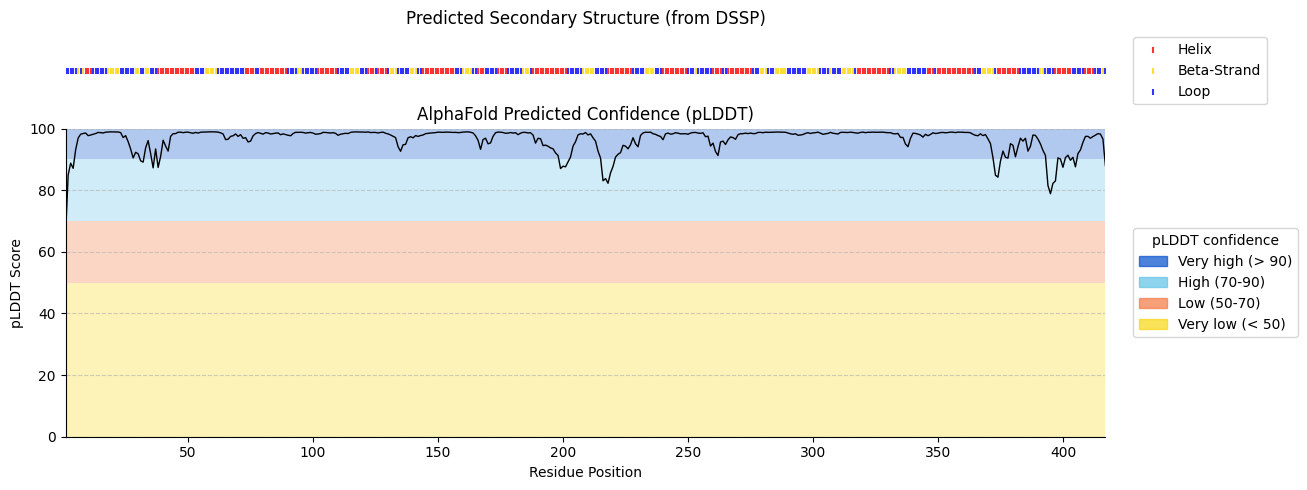

In [16]:
#@title Plot plddt and secondary structure
# --------Create the Combined Plot (pLDDT and Sec Struct)
print("\n--- Plot (pLDDT / Sec Struct) ---")
fig, axes = plt.subplots(
    nrows=2, ncols=1, sharex=True, figsize=(15, 5),
    gridspec_kw={'height_ratios': [1, 4]}
)
plot_secondary_structure_on_ax(axes[0], residues, sec_structs_aligned)
plot_plddt_on_ax(axes[1], residues, plddt_scores)
axes[1].set_xlabel("Residue Position")
min_res, max_res = min(residues), max(residues)
axes[1].set_xlim(min_res, max_res)
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.subplots_adjust(hspace=0.1)
plt.show()

# <font color='#e59454' >6.Predicted Aligned Erorr (PAE)


--- py3Dmol ---


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

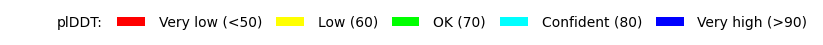

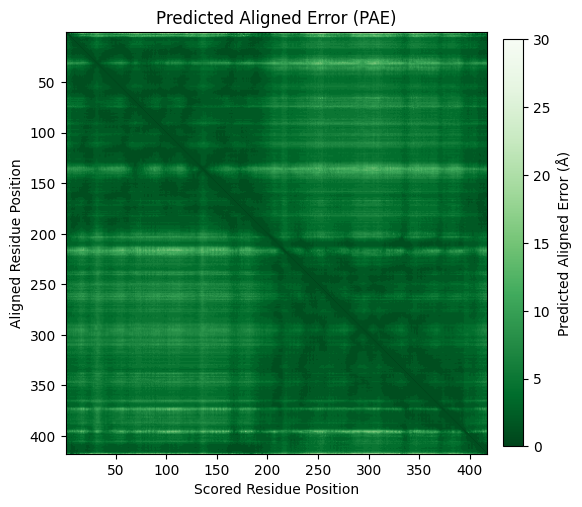

PAE plot displayed.


In [17]:
#@title Visualise structure and PAE

print("\n--- py3Dmol ---")
#legend colours
def plot_plddt_legend(dpi=100):
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt
plot_plddt_legend()

# py3dmol
with open(pdb_path, 'r') as f:
    pdb_data = f.read()
view = py3Dmol.view(width=600, height=400)
view.addModel(pdb_data, 'pdb')
view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'color': 'white'})
view.zoomTo() # Zoom to structure
view.show()


if 'pae_matrix' in locals() and pae_matrix is not None:
    fig_pae, ax_pae = plt.subplots(figsize=(6, 6))

    # Plot the PAE matrix using the dedicated function
    try:
      im = plot_pae_on_ax(ax_pae, pae_matrix)
    except NameError:
        print("ERROR: 'plot_pae_on_ax' function not defined. Please run Cell 4 first.")
        raise


    # Add a color bar
    cbar = fig_pae.colorbar(im, ax=ax_pae, shrink=0.75, aspect=20, pad=0.03)
    cbar.set_label("Predicted Aligned Error (Å)")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout, leave space for suptitle if added
    # fig_pae.suptitle(f"PAE Matrix for {uniprot_id}", fontsize=14) # Optional overall title
    plt.show()
    print("PAE plot displayed.")

elif 'pae_file_path' in locals() and pae_file_path is not None:
     print(f"ERROR: PAE matrix data ('pae_matrix') not loaded. Attempting to load from {pae_file_path}...")
     # Try loading here if Cell 5 wasn't run or modified
     pae_matrix = load_pae_matrix(pae_file_path)
     if pae_matrix is not None:
         # Now try plotting again
         print("\n--- Generating PAE Plot (after manual load) ---")
         fig_pae, ax_pae = plt.subplots(figsize=(8, 7))
         im = plot_pae_on_ax(ax_pae, pae_matrix)
         cbar = fig_pae.colorbar(im, ax=ax_pae, shrink=0.75, aspect=20, pad=0.03)
         cbar.set_label("Predicted Aligned Error (Å)")
         plt.tight_layout(rect=[0, 0, 1, 0.96])
         plt.show()
     else:
        print("ERROR: Failed to load PAE matrix manually.")

# <font color='#e59454' >7.DSSP Accessibility
**Solvent Accessibility Calculation**

**The Basics: <br>**
- Solvent accessibility refers to how much of a protein's surface is exposed to the surrounding solvent (typically water).
- It's a crucial property because it influences protein folding, stability, and interactions with other molecules.

**How it Works:**
- DSSP calculates solvent accessibility by rolling a probe (representing a water molecule) over the protein's surface.
It determines the surface area that is accessible to this probe.
- The output is a value representing the solvent-accessible surface area (ASA) for each amino acid residue.
- This value is essentially the number of water contacts that a residue has.
Residues buried inside the protein have low ASA values, while those on the surface have high values.

**Significance:**
- High ASA residues are often involved in interactions with other proteins or ligands.
- Low ASA residues are typically found in the hydrophobic core of the protein, contributing to its stability.


--- Generating Combined Plot (pLDDT / DSSP Accessibility) ---


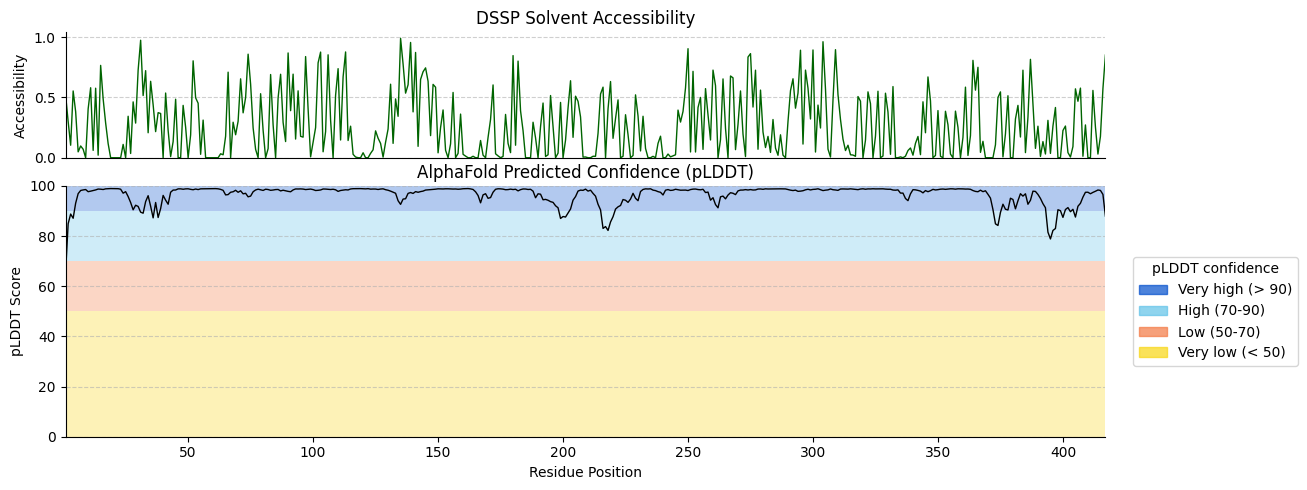


Combined plot displayed successfully.


In [18]:
#@title Plot pLDDT vs DSSP Accessibility
# plotting function specifically for DSSP Accessibility
def plot_accessibility_on_ax(ax: plt.Axes, residues: list[int], accessibility: list[float]):
    """
    Plots DSSP accessibility values as a line plot onto a Matplotlib Axes.
    """
    if not residues or not accessibility:
         ax.text(0.5, 0.5, "No Accessibility data", ha='center', va='center', transform=ax.transAxes)
         return

    # Plot accessibility as a line
    ax.plot(residues, accessibility, color="darkgreen", linewidth=1.0, label="DSSP Acc.")

    # --- Appearance ---
    ax.set_title("DSSP Solvent Accessibility")
    ax.set_ylabel("Accessibility") # Units are related to water contacts
    ax.set_ylim(bottom=0) # Start y-axis at 0
    ax.grid(axis='y', linestyle='--', alpha=0.6) # Add horizontal grid
    ax.spines[["right", "top"]].set_visible(False) # Hide top/right spines
    # Hide x-axis ticks and labels for the top plot (shared axis)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    # Optional: Add a legend if desired, though with one line it might be redundant
    # ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))


# --- Check if data exists from previous cell ---
if 'residues' in locals() and 'plddt_scores' in locals() and 'accessibility_aligned' in locals():
    print("\n--- Generating Combined Plot (pLDDT / DSSP Accessibility) ---")

    # Create figure with 2 vertically stacked plots sharing the x-axis
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        sharex=True,
        figsize=(15, 5), # Keep consistent width, adjust height if needed
        # Adjust height ratios: give accessibility plot a bit more space than SS plot had
        gridspec_kw={'height_ratios': [2, 4]}
    )

    # Plot DSSP Accessibility on top axis (axes[0])
    plot_accessibility_on_ax(axes[0], residues, accessibility_aligned)

    # Plot pLDDT on bottom axis (axes[1])
    # Make sure plot_plddt_on_ax is defined (run Cell 4 if needed)
    try:
        plot_plddt_on_ax(axes[1], residues, plddt_scores)
    except NameError:
        print("ERROR: 'plot_plddt_on_ax' function not defined. Please run Cell 4 first.")
        raise

    # Configure the final shared X-axis
    axes[1].set_xlabel("Residue Position")
    min_res = min(residues)
    max_res = max(residues)
    axes[1].set_xlim(min_res, max_res) # Set tight limits

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust for pLDDT legend
    plt.subplots_adjust(hspace=0.15) # Adjust vertical space slightly
    plt.show()
    print("\nCombined plot displayed successfully.")

else:
    print("ERROR: Required data ('residues', 'plddt_scores', 'accessibility_aligned') not found.")
    print("Please ensure the previous cell (Cell 5) was run successfully.")


--- Generating Contact Map Plot for AF-P00558-F1-model_v4.pdb ---
Generating contact map with CA-CA cutoff = 8.0 Å...
Contact map generated for 417 residues. Found 2192 contacts.


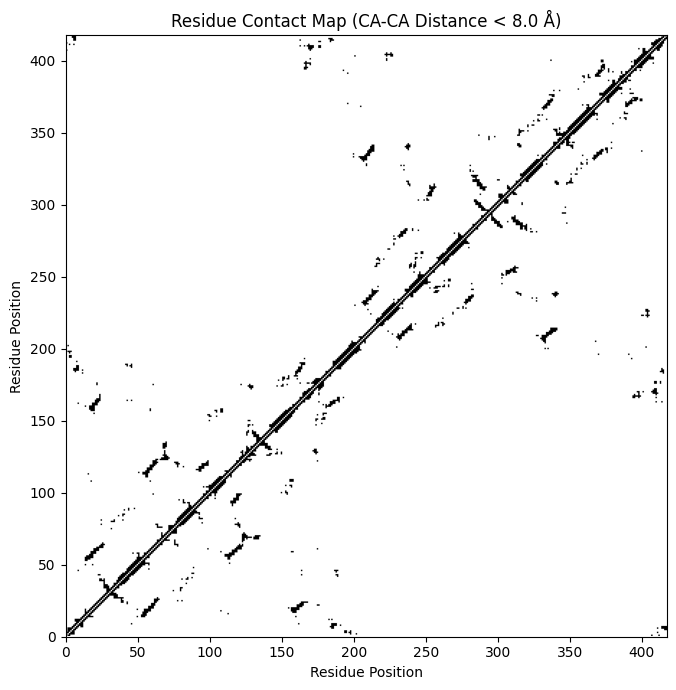

Contact map plot displayed.


In [19]:
#@title 8. Contact map

from scipy.spatial.distance import pdist, squareform
# from Bio.PDB import PDBParser # Should be imported in Cell 2

def plot_contact_map(ax: plt.Axes, pdb_file: str, cutoff: float = 9.0):
    """
    Calculates and plots a C-alpha contact map on a Matplotlib Axes.
    Axes will visually start from 0.

    Args:
        ax: The Matplotlib Axes object to plot on.
        pdb_file: Path to the PDB file.
        cutoff: The distance cutoff (in Angstroms) for defining a contact.

    Returns:
        True if the plot was generated successfully, False otherwise.
    """
    print(f"Generating contact map with CA-CA cutoff = {cutoff} Å...")
    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("contact_map_struct", pdb_file)
        model = structure[0]

        ca_atoms = []
        residue_ids = []
        # Collect C-alpha atoms and their residue numbers from standard residues
        for chain in model:
            for residue in chain:
                hetfield, resseq, icode = residue.get_id()
                if hetfield == ' ' and 'CA' in residue: # Standard AA with C-alpha
                    ca_atoms.append(residue['CA'])
                    residue_ids.append(resseq)

        num_residues = len(ca_atoms)
        if num_residues < 2:
            print("ERROR: Not enough C-alpha atoms found (< 2) to create a contact map.")
            ax.text(0.5, 0.5, "Not enough data\nfor contact map", ha='center', va='center', transform=ax.transAxes)
            return False

        min_res, max_res = min(residue_ids), max(residue_ids)

        # Extract coordinates into a NumPy array
        coords = np.array([atom.get_coord() for atom in ca_atoms])

        # Calculate pairwise distances efficiently
        dist_matrix = squareform(pdist(coords))

        # Create boolean contact matrix based on cutoff
        contact_matrix = dist_matrix < cutoff
        np.fill_diagonal(contact_matrix, False) # Remove self-contacts

        # Plotting
        # Extent maps matrix indices (0..N-1) to residue numbers (min_res..max_res)
        plot_extent = [min_res - 0.5, max_res + 0.5, max_res + 0.5, min_res - 0.5]

        ax.imshow(contact_matrix, cmap='Greys', origin='upper', extent=plot_extent)
        ax.set_title(f'Residue Contact Map (CA-CA Distance < {cutoff} Å)')
        ax.set_xlabel('Residue Position')
        ax.set_ylabel('Residue Position')

        # --- Set Axis Limits to start visually at 0 ---
        ax.set_xlim(0, max_res + 0.5) # Start x-axis at 0
        ax.set_ylim(0, max_res + 0.5) # End y-axis at 0 (inverted for origin='upper')
        # -----------------------------------------------

        num_contacts = np.sum(contact_matrix) // 2
        print(f"Contact map generated for {num_residues} residues. Found {num_contacts} contacts.")
        return True

    except FileNotFoundError:
         print(f"ERROR: PDB file not found at {pdb_file}")
         ax.text(0.5, 0.5, f"PDB file not found:\n{os.path.basename(pdb_file)}", ha='center', va='center', transform=ax.transAxes, color='red')
         return False
    except ImportError as import_err:
         print(f"ERROR: Missing library for contact map ({import_err}). Please check Cell 1 installation.")
         ax.text(0.5, 0.5, "Missing library (SciPy?)", ha='center', va='center', transform=ax.transAxes, color='red')
         return False
    except Exception as e:
        print(f"ERROR generating contact map: {e}")
        # traceback.print_exc() # Uncomment for detailed debug info
        ax.text(0.5, 0.5, "Error generating\ncontact map", ha='center', va='center', transform=ax.transAxes, color='red')
        return False


# --- Main Plotting Logic for Contact Map ---

#@markdown Distance cutoff (Angstroms) for C-alpha contacts:
contact_cutoff = 8.0 #@param {type:"number"}

# Check if pdb_path variable exists from Cell 5
if 'pdb_path' in locals() and pdb_path is not None and os.path.exists(pdb_path):
    print(f"\n--- Generating Contact Map Plot for {os.path.basename(pdb_path)} ---")
    fig_cm, ax_cm = plt.subplots(figsize=(8, 7)) # Adjust size as needed

    # Plot the contact map using the dedicated function
    success = plot_contact_map(ax_cm, pdb_path, cutoff=contact_cutoff)

    if success:
      plt.tight_layout()
      plt.show()
      print("Contact map plot displayed.")
    else:
      plt.close(fig_cm) # Close the figure if plotting failed
      print("Contact map plot generation failed.")

else:
    print("ERROR: PDB file path ('pdb_path') not found or file does not exist.")
    print("Please ensure the main execution cell (Cell 5) was run successfully and downloaded the PDB file.")

